# **Thiết lập môi trường Pyspark**

In [5]:
# Kết nối Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# !sudo apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://archive.apache.org/dist/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
!cp /content/drive/MyDrive/final_mmds/pyspark/spark-3.5.4-bin-hadoop3.tgz .
!cp /content/drive/MyDrive/final_mmds/source/task3/df_10d.csv .
!tar xf spark-3.5.4-bin-hadoop3.tgz
!pip install -q findspark

In [7]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"

In [8]:
import findspark
import pyspark as spark
findspark.init()
print(spark.__version__)

3.5.1


# **Khởi tạo SparkSession và các thư viện cần thiết**

In [9]:
# --- PySpark Core và SQL ---
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import (
    col, to_date, year, month, dayofmonth, dayofweek,
    lag, desc, monotonically_increasing_id, udf,
    sum as spark_sum, avg as spark_avg, split,
    min as spark_min, max as spark_max, count as spark_count
)
from pyspark.sql.window import Window
from pyspark.sql.types import (
    DoubleType, DateType, StructType,
    ArrayType, FloatType, StringType,
    StructField)
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

# --- Python Libraries ---
import pandas as pd
import shutil
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tabulate import tabulate

# Thiết lập một số tùy chỉnh cho đồ thị
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# **Working_path**

In [10]:
working_path = "."

In [11]:
# Khởi tạo SparkSession
spark = SparkSession.builder.appName("Task3DimensionalityReduction").getOrCreate()
print("SparkSession đã được khởi tạo.")

SparkSession đã được khởi tạo.


**Tải dữ liệu từ Task2**

In [15]:
# Đường dẫn đến file CSV (dữ liệu 10 chiều)
file_path = f"{working_path}/df_10d.csv"

# Định nghĩa schema cho DataFrame 10 chiều
schema_10d = StructType([
    StructField("Date", StringType(), True),
    StructField("features_vector", StringType(), True),
    StructField("label", FloatType(), True)
])

# Đọc file CSV vào DataFrame 10 chiều
df_10d = spark.read.csv(file_path, header=True, schema=schema_10d)

# Chuyển đổi cột 'features_vector' từ chuỗi sang vector
def string_to_float_array(s):
    s = s.strip("[]")
    return [float(x) for x in s.split(",")]

string_to_float_array_udf = udf(string_to_float_array, ArrayType(FloatType()))
df_10d = df_10d.withColumn("features_array", string_to_float_array_udf(col("features_vector"))).drop("features_vector")
df_10d.show(5, truncate=False)

+----------+-----+----------------------------------------------------------------------+
|Date      |label|features_array                                                        |
+----------+-----+----------------------------------------------------------------------+
|2009-08-11|21.19|[21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19]|
|2009-08-12|21.19|[21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19]|
|2009-08-13|21.19|[21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19]|
|2009-08-14|21.19|[21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19]|
|2009-08-15|21.19|[21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19, 21.19]|
+----------+-----+----------------------------------------------------------------------+
only showing top 5 rows



# **Task 3: CUR – Dimensionality Reduction**

**Triển khai thuật toán CUR giảm df_10d xuống df_5d**

In [18]:
class CURReducer:
    def __init__(self, num_columns_to_select=5, num_rows_to_select=5, seed=1024):
        self.k = num_columns_to_select
        self.r = num_rows_to_select
        self.seed = seed
        self.selected_col_indices = None
        self.selected_row_indices = None

    def _build_row_matrix(self, df_vector):
        # Chuyển sang RDD[Vectors.dense]
        return RowMatrix(df_vector.rdd.map(lambda row: Vectors.dense(row["features_array"])))

    def fit_transform(self, df_vector):
        matrix = self._build_row_matrix(df_vector)
        A = np.array(matrix.rows.collect())  # A: m x n
        m, n = A.shape

        def sample_columns(A, c, seed):
            col_norms_sq = np.sum(A**2, axis=0) # Tính Frobenius norm
            prob_cols = col_norms_sq / np.sum(col_norms_sq)
            np.random.seed(seed)
            selected_col_indices = np.random.choice(n, c, replace=False, p=prob_cols)
            C = np.zeros((m, c))
            for i, j in enumerate(selected_col_indices): # Chọn ngẫu nhiên dựa trên prob
                C[:, i] = A[:, j] / np.sqrt(c * prob_cols[j]) # Chuẩn hóa
            return C, selected_col_indices

        def sample_rows(A, r, seed):
            row_norms_sq = np.sum(A**2, axis=1)
            prob_rows = row_norms_sq / np.sum(row_norms_sq) # Tính Frobenius norm
            np.random.seed(seed)
            selected_row_indices = np.random.choice(m, r, replace=False, p=prob_rows)
            R = np.zeros((r, n))
            for i, idx in enumerate(selected_row_indices): # Chọn ngẫu nhiên dựa trên prob
                R[i, :] = A[idx, :] / np.sqrt(r * prob_rows[idx]) # Chuẩn hóa
            return R, selected_row_indices

        C, self.selected_col_indices = sample_columns(A, self.k, self.seed)
        R, self.selected_row_indices = sample_rows(A, self.r, self.seed + 1)

        # Ma trận W: giao nhau giữa hàng và cột đã chọn
        W = A[np.ix_(self.selected_row_indices, self.selected_col_indices)]  # W: r x k

        # Tạo RDD từ ma trận W
        W_rdd = spark.sparkContext.parallelize(W.tolist())
        W_mat = RowMatrix(W_rdd.map(lambda row: Vectors.dense(row)))

        # Tính SVD để lấy X, Y, Z
        svd = W_mat.computeSVD(self.k, computeU=True)
        X = np.array(svd.U.rows.collect())  # r x k
        Z = svd.s.toArray()                 # Vector kích thước k
        Y = np.array(svd.V.toArray())       # k x k

        Z_inv_squared = np.diag([(1/s)**2 if s > 1e-10 else 0 for s in Z])
        U = Y @ Z_inv_squared @ X.T

        return C, U, R


In [20]:
# Khởi tạo và áp dụng CUR
cur = CURReducer(num_columns_to_select=5, num_rows_to_select=5)
c, u ,r = cur.fit_transform(df_10d.select("features_array"))

# Chuyển kết quả về DataFrame
df_5d = spark.createDataFrame([
    Row(
        Date=row["Date"],
        label=round(float(row["label"]), 2),
        features_cur=list(map(float, c[i]))
    )
    for i, row in enumerate(df_10d.collect())
])

df_5d.show(5, truncate=False)

+----------+-----+--------------------------------------------------------------------------------------------------+
|Date      |label|features_cur                                                                                      |
+----------+-----+--------------------------------------------------------------------------------------------------+
|2009-08-11|21.19|[29.97894721617453, 30.00251096677933, 29.971104961895673, 29.986795629701223, 29.931985797919356]|
|2009-08-12|21.19|[29.97894721617453, 30.00251096677933, 29.971104961895673, 29.986795629701223, 29.931985797919356]|
|2009-08-13|21.19|[29.97894721617453, 30.00251096677933, 29.971104961895673, 29.986795629701223, 29.931985797919356]|
|2009-08-14|21.19|[29.97894721617453, 30.00251096677933, 29.971104961895673, 29.986795629701223, 29.931985797919356]|
|2009-08-15|21.19|[29.97894721617453, 30.00251096677933, 29.971104961895673, 29.986795629701223, 29.931985797919356]|
+----------+-----+--------------------------------------

**Lưu file df_5d.csv**

In [21]:
# UDF chuyển array -> string
array_to_string_udf = udf(lambda arr: ','.join([str(round(x, 4)) for x in arr]), StringType())
working_path = "."
# Thêm cột chuỗi để lưu CSV
df_5d_export = df_5d.withColumn("features_cur_str", array_to_string_udf(col("features_cur"))) \
                    .drop("features_cur")

# Các đường dẫn lưu file
temp_output_dir_5d = f"{working_path}/dataframe_task3_temp_5d"
final_output_dir_5d = f"{working_path}/"
final_filename_5d = "df_5d.csv"

# Xoá thư mục tạm nếu có
shutil.rmtree(temp_output_dir_5d, ignore_errors=True)

# Lưu file tạm
df_5d_export.coalesce(1).write.mode("overwrite").option("header", True).csv(temp_output_dir_5d)

# Tìm file part-*.csv
part_file_5d = glob.glob(os.path.join(temp_output_dir_5d, "part-*.csv"))[0]

# Tạo thư mục đích
os.makedirs(final_output_dir_5d, exist_ok=True)

# Đổi tên file và di chuyển
shutil.move(part_file_5d, os.path.join(final_output_dir_5d, final_filename_5d))

# Xoá thư mục tạm
shutil.rmtree(temp_output_dir_5d)

print(f"Đã lưu file CSV thành: {os.path.join(final_output_dir_5d, final_filename_5d)}")

Đã lưu file CSV thành: ./df_5d.csv


# **Linear regression model**

**Xây dựng lớp GoldPricePredictor sử dụng mô hình Linear Regression để dự đoán**

In [22]:
class GoldPricePredictor:
    def __init__(self, features_col="features_vector", label_col="label", prediction_col="prediction",
                 max_iter=100, reg_param=0.001, elastic_net_param=0.001,
                 fit_intercept=True, standardization=True, solver="auto"):
        """
        Khởi tạo mô hình dự đoán giá vàng.

        Args:
            features_col (str): Tên cột chứa vector đặc trưng.
            label_col (str): Tên cột chứa nhãn.
            prediction_col (str): Tên cột chứa giá trị dự đoán.
            max_iter (int): Số vòng lặp tối đa.
            reg_param (float): Tham số điều chuẩn.
            elastic_net_param (float): Tham số trộn Elastic Net.
            fit_intercept (bool): Có sử dụng hệ số chặn hay không.
            standardization (bool): Có chuẩn hóa features hay không.
            solver (str): Thuật toán giải.
        """
        self.features_col = features_col
        self.label_col = label_col
        self.prediction_col = prediction_col

        self.lr_estimator = LinearRegression(
            featuresCol=self.features_col,
            labelCol=self.label_col,
            predictionCol=self.prediction_col,
            maxIter=max_iter,
            regParam=reg_param,
            elasticNetParam=elastic_net_param,
            fitIntercept=fit_intercept,
            standardization=standardization,
            solver=solver
        )

        self.model = None
        self.training_summary = None
        self.objective_history = []
        self.metrics = {}
        self.feature_names_list = []
        self.target_price_display_name = "prediction"

    def set_feature_names(self, feature_names):
        self.feature_names_list = feature_names
        return self

    def set_target_price_display_name(self, name):
        self.target_price_display_name = name
        return self

    def train(self, training_data):
        """
        Huấn luyện mô hình Linear Regression.
        Args:
            training_data (DataFrame): Tập dữ liệu training của PySpark
                                     (phải chứa cột features_col và label_col).
        """
        if not training_data:
            print("Lỗi: training_data không được cung cấp.")
            self.model = None
            return None

        print(f"Bắt đầu huấn luyện mô hình Linear Regression ({self.target_price_display_name}) với các tham số:")
        print(f"  MaxIter: {self.lr_estimator.getMaxIter()}, \
        RegParam: {self.lr_estimator.getRegParam()}, \
        ElasticNetParam: {self.lr_estimator.getElasticNetParam()}")
        print(f"  FitIntercept: {self.lr_estimator.getFitIntercept()}, \
        Standardization: {self.lr_estimator.getStandardization()}, \
        Solver: {self.lr_estimator.getSolver()}")

        self.model = self.lr_estimator.fit(training_data)

        self.training_summary = self.model.summary
        self.objective_history = self.training_summary.objectiveHistory

        print("Hoàn thành huấn luyện mô hình.")
        self._print_coefficients()
        return self.model

    def _print_coefficients(self):
        print(f"\nIntercept (hệ số chặn): {self.model.intercept:.4f}")
        print("Coefficients (hệ số cho mỗi đặc trưng):")
        if self.feature_names_list and len(self.feature_names_list) == len(self.model.coefficients):
            for name, coef in zip(self.feature_names_list, self.model.coefficients):
                print(f"  {name}: {coef:.4f}")
        else:
            for i, coef in enumerate(self.model.coefficients):
                print(f"  Feature_{i+1}: {coef:.4f}")


    def plot_objective_history(self):
        print("\nLịch sử hàm mục tiêu (Objective History) qua các vòng lặp huấn luyện:")
        table_data = [(i + 1, f"{obj_val:.6f}") for i, obj_val in enumerate(self.objective_history)]
        headers = ["Iteration", "Objective Value"]
        print(tabulate(table_data, headers=headers, tablefmt="grid"))

        plt.figure(figsize=(10, 6))
        plt.plot(range(len(self.objective_history)), self.objective_history, marker='o', linestyle='-')
        plt.title(f'Lịch Sử Hàm Mục Tiêu (Losses) - {self.target_price_display_name}')
        plt.xlabel('Vòng Lặp Tối Ưu Hóa (Iteration)')
        plt.ylabel('Giá Trị Hàm Mục Tiêu')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def evaluate(self, training_data, test_data):
        if not self.model:
            print("Mô hình chưa được huấn luyện.")
            return None
        if not training_data or not test_data:
            print("Lỗi: Cần training_data và test_data để đánh giá.")
            return None

        print("\nĐánh giá mô hình...")
        predictions_train = self.model.transform(training_data)
        predictions_test = self.model.transform(test_data)

        evaluator_rmse = RegressionEvaluator(labelCol=self.label_col, \
                                             predictionCol=self.prediction_col, \
                                             metricName="rmse")
        evaluator_r2 = RegressionEvaluator(labelCol=self.label_col, predictionCol=self.prediction_col, metricName="r2")
        evaluator_mae = RegressionEvaluator(labelCol=self.label_col, predictionCol=self.prediction_col, metricName="mae")

        self.metrics = {
            'train_rmse': evaluator_rmse.evaluate(predictions_train),
            'train_r2': evaluator_r2.evaluate(predictions_train),
            'train_mae': evaluator_mae.evaluate(predictions_train),
            'test_rmse': evaluator_rmse.evaluate(predictions_test),
            'test_r2': evaluator_r2.evaluate(predictions_test),
            'test_mae': evaluator_mae.evaluate(predictions_test)
        }

        print(f"\nKết quả trên tập Training (dự đoán cho {self.target_price_display_name}):")
        print(f"  RMSE: {self.metrics['train_rmse']:.3f}, MAE: {self.metrics['train_mae']:.3f}, R2: {self.metrics['train_r2']:.3f}")
        print(f"\nKết quả trên tập Test (dự đoán cho {self.target_price_display_name}):")
        print(f"  RMSE: {self.metrics['test_rmse']:.3f}, MAE: {self.metrics['test_mae']:.3f}, R2: {self.metrics['test_r2']:.3f}")
        return self.metrics

    def plot_evaluation_comparison(self):
        """Vẽ biểu đồ cột so sánh các metrics trên tập training và test."""
        if not self.metrics or 'train_rmse' not in self.metrics:
            print("Chưa có metrics để vẽ. Vui lòng chạy evaluate() trước.")
            return

        metrics_names = ['RMSE', 'MAE', 'R2']
        train_values = [self.metrics.get('train_rmse', float('nan')),
                        self.metrics.get('train_mae', float('nan')),
                        self.metrics.get('train_r2', float('nan'))]
        test_values = [self.metrics.get('test_rmse', float('nan')),
                       self.metrics.get('test_mae', float('nan')),
                       self.metrics.get('test_r2', float('nan'))]

        x_indices = range(len(metrics_names))
        plt.figure(figsize=(12, 7))
        bar_width = 0.35
        rects_train = plt.bar([i - bar_width/2 for i in x_indices], train_values, bar_width, label='Training Set', color='deepskyblue')
        rects_test = plt.bar([i + bar_width/2 for i in x_indices], test_values, bar_width, label='Test Set', color='lightcoral')

        plt.ylabel('Giá trị Metric')
        plt.title(f'So Sánh Kết Quả Đánh Giá Mô Hình ({self.target_price_display_name})')
        plt.xticks(x_indices, metrics_names)
        plt.legend()

        def add_labels(rects):
            for rect in rects:
                height = rect.get_height()
                if not pd.isna(height):
                    plt.text(rect.get_x() + rect.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')
        add_labels(rects_train)
        add_labels(rects_test)
        plt.tight_layout()
        plt.show()

    def predict(self, data_with_features):
        """
        Đưa ra dự đoán trên dữ liệu mới (đã được assembled thành features_vector).
        Args:
            data_with_features (DataFrame): PySpark DataFrame chứa cột features_col.
        Returns:
            DataFrame: DataFrame với cột predictionCol được thêm vào.
        """
        if not self.model:
            print("Mô hình chưa được huấn luyện. Không thể dự đoán.")
            return None
        if self.features_col not in data_with_features.columns:
            print(f"Lỗi: Dữ liệu mới không có cột feature '{self.features_col}'.")
            return None

        print("Đưa ra dự đoán trên dữ liệu mới...")
        predictions = self.model.transform(data_with_features)
        return predictions


# **Thực nghiệm**

**Chuẩn bị dữ liệu**

In [28]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import *

# UDF chuyển array -> DenseVector
to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())
# Áp dụng cho df_10d
df_10d_vector = df_10d.withColumn("features_vector", to_vector_udf("features_array")).drop('features_array')
# Áp dụng cho df_5d
df_5d_vector = df_5d.withColumn("features_vector", to_vector_udf("features_cur")).drop('features_cur')
df_10d_vector.show(5, truncate=False)
df_5d_vector.show(5, truncate=False)

+----------+-----+-------------------------------------------------------------+
|Date      |label|features_vector                                              |
+----------+-----+-------------------------------------------------------------+
|2009-08-11|21.19|[21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19]|
|2009-08-12|21.19|[21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19]|
|2009-08-13|21.19|[21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19]|
|2009-08-14|21.19|[21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19]|
|2009-08-15|21.19|[21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19]|
+----------+-----+-------------------------------------------------------------+
only showing top 5 rows

+----------+-----+----------------------------------------------------------------------------------------------+
|Date      |label|features_vector                                                                               |
+----------+-----+

**Chia tập dữ liệu**

In [29]:
train_10d, test_10d = df_10d_vector.randomSplit([0.7, 0.3], seed=42)
train_5d, test_5d = df_5d_vector.randomSplit([0.7, 0.3], seed=42)
print(f"Train size: {train_10d.count()}\nTest size: {test_10d.count()}")

Train size: 3964
Test size: 1591


**Huấn luyện mô hình trên 10 chiều:**

In [31]:
# Mô hình với 10 chiều
model_10d = GoldPricePredictor(
    features_col="features_vector",
    label_col="label",
    prediction_col="prediction_10d",
    max_iter=500,
    reg_param=0.01,
    elastic_net_param=0.01
)
model_10d.set_target_price_display_name("GoldPrice_10D")
model_10d.train(train_10d)
metrics_10d = model_10d.evaluate(train_10d, test_10d)


Bắt đầu huấn luyện mô hình Linear Regression (GoldPrice_10D) với các tham số:
  MaxIter: 500,         RegParam: 0.01,         ElasticNetParam: 0.01
  FitIntercept: True,         Standardization: True,         Solver: auto
Hoàn thành huấn luyện mô hình.

Intercept (hệ số chặn): 0.0051
Coefficients (hệ số cho mỗi đặc trưng):
  Feature_1: 0.5663
  Feature_2: 0.1670
  Feature_3: 0.1357
  Feature_4: 0.0868
  Feature_5: 0.0494
  Feature_6: 0.0376
  Feature_7: 0.0238
  Feature_8: 0.0018
  Feature_9: -0.0414
  Feature_10: -0.0268

Đánh giá mô hình...

Kết quả trên tập Training (dự đoán cho GoldPrice_10D):
  RMSE: 0.353, MAE: 0.170, R2: 0.999

Kết quả trên tập Test (dự đoán cho GoldPrice_10D):
  RMSE: 0.321, MAE: 0.154, R2: 1.000


# Huấn luyện mô hình trên 5 chiều dữ liệu

In [32]:
# Mô hình với 5 chiều
model_5d = GoldPricePredictor(
    features_col="features_vector",
    label_col="label",
    prediction_col="prediction_5d",
    max_iter=500,
    reg_param=0.01,
    elastic_net_param=0.01
)
model_5d.set_target_price_display_name("GoldPrice_5D")
model_5d.train(train_5d)
metrics_5d = model_5d.evaluate(train_5d, test_5d)

Bắt đầu huấn luyện mô hình Linear Regression (GoldPrice_5D) với các tham số:
  MaxIter: 500,         RegParam: 0.01,         ElasticNetParam: 0.01
  FitIntercept: True,         Standardization: True,         Solver: auto
Hoàn thành huấn luyện mô hình.

Intercept (hệ số chặn): 0.0173
Coefficients (hệ số cho mỗi đặc trưng):
  Feature_1: 0.0550
  Feature_2: -0.0304
  Feature_3: 0.1232
  Feature_4: 0.0086
  Feature_5: 0.5514

Đánh giá mô hình...

Kết quả trên tập Training (dự đoán cho GoldPrice_5D):
  RMSE: 0.348, MAE: 0.170, R2: 0.999

Kết quả trên tập Test (dự đoán cho GoldPrice_5D):
  RMSE: 0.326, MAE: 0.156, R2: 1.000


**Vẽ biểu đồ so sánh các chỉ số giữa 10D và 5D:**

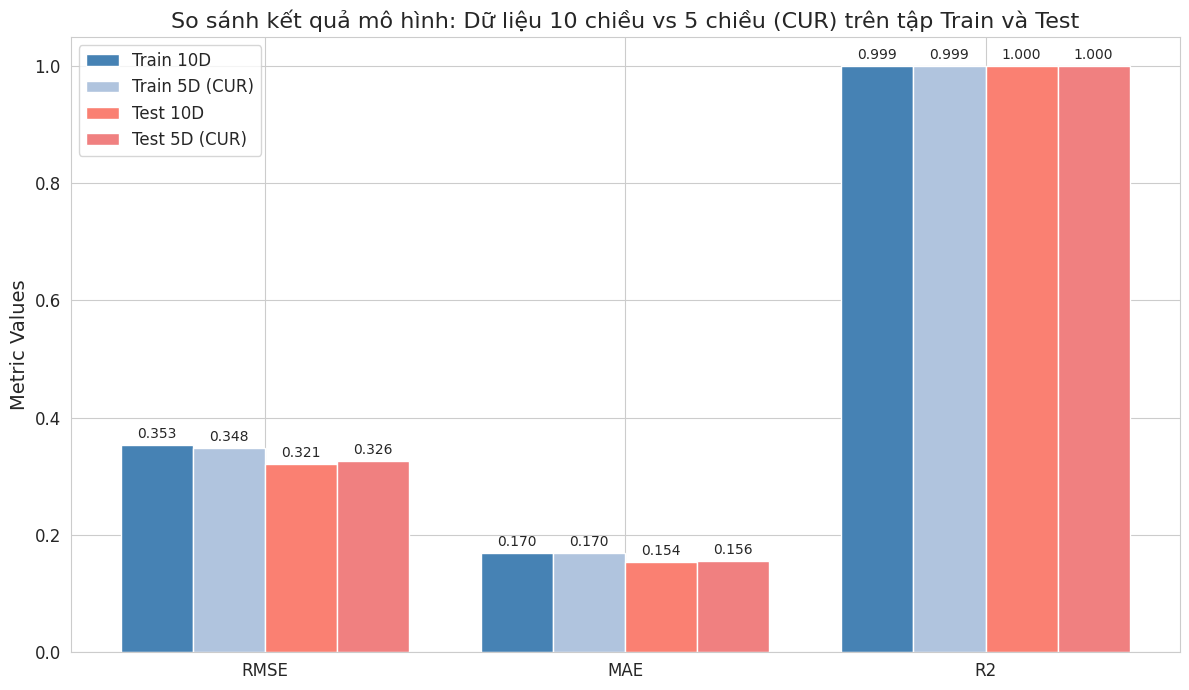

In [33]:
labels = ['RMSE', 'MAE', 'R2']
x = np.arange(len(labels))  # vị trí x
width = 0.2  # nhỏ hơn để vừa 4 nhóm cột

fig, ax = plt.subplots(figsize=(12, 7))

# Dữ liệu train
train_10d = [metrics_10d['train_rmse'], metrics_10d['train_mae'], metrics_10d['train_r2']]
train_5d = [metrics_5d['train_rmse'], metrics_5d['train_mae'], metrics_5d['train_r2']]

# Dữ liệu test
test_10d = [metrics_10d['test_rmse'], metrics_10d['test_mae'], metrics_10d['test_r2']]
test_5d = [metrics_5d['test_rmse'], metrics_5d['test_mae'], metrics_5d['test_r2']]

rects1 = ax.bar(x - 1.5*width, train_10d, width, label='Train 10D', color='steelblue')
rects2 = ax.bar(x - 0.5*width, train_5d, width, label='Train 5D (CUR)', color='lightsteelblue')
rects3 = ax.bar(x + 0.5*width, test_10d, width, label='Test 10D', color='salmon')
rects4 = ax.bar(x + 1.5*width, test_5d, width, label='Test 5D (CUR)', color='lightcoral')

ax.set_ylabel('Metric Values')
ax.set_title('So sánh kết quả mô hình: Dữ liệu 10 chiều vs 5 chiều (CUR) trên tập Train và Test')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

for rects in [rects1, rects2, rects3, rects4]:
    autolabel(rects)

plt.tight_layout()
plt.show()


**Nhận xét:**

* Mô hình Linear Regression với cả 10 đặc trưng gốc và 5 đặc trưng sau giảm chiều bằng CUR đều cho kết quả dự đoán rất tốt, với RMSE và MAE thấp, R² gần 1 trên tập train và test.

* Việc giảm chiều dữ liệu từ 10 xuống 5 đặc trưng không làm giảm đáng kể hiệu suất mô hình, cho thấy CUR đã chọn được những đặc trưng quan trọng nhất.

* Hệ số hồi quy của các đặc trưng sau CUR phản ánh rõ mức độ ảnh hưởng khác nhau tới giá vàng.

**Giải thích:**

* CUR chọn các cột và hàng quan trọng dựa trên phân phối năng lượng của ma trận dữ liệu, giúp giữ lại thông tin có ý nghĩa nhất.

* Do đó, mô hình với 5 đặc trưng CUR vẫn có đủ thông tin để dự đoán chính xác như mô hình đầy đủ 10 đặc trưng.

* Kết quả R² rất cao chứng tỏ mối quan hệ tuyến tính giữa các đặc trưng và giá vàng là rõ ràng, đồng thời việc sử dụng regularization giúp mô hình tránh hiện tượng overfitting.

* RMSE và MAE thấp trên cả tập train và test cho thấy mô hình tổng quát tốt, dữ liệu train-test không khác biệt quá lớn.

# **Dừng SparkSession**

In [34]:
def stop_session():
    spark.stop()
    print("SparkSession đã được dừng.")

# stop_session()